In [43]:
from BayesianOptimization.bayes_opt.bayesian_optimization import BayesianOptimization
import BayesianOptimization.bayes_opt.helpers

In [44]:
import sys
import numpy as np 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import inspect
from matplotlib import gridspec
%matplotlib inline  
%load_ext autoreload
%autoreload 2
%aimport BayesianOptimization.bayes_opt.bayesian_optimization
%aimport BayesianOptimization.bayes_opt.helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Brian Function Simulation

From the paper I read this week, they use Brian function as testing function for global optimization problem. As you can observe from contour map above, we have 3 global minimum and no local minimum. 

In [22]:
# Numerical decisions
N = 1000
x1 = np.linspace(-5, 10, N, endpoint=True)
x2 = np.linspace(0, 15, N, endpoint=True)

def Brainfunction(x1,x2):
    # Parameters of the function
    PI = 3.14159265359
    a = 1;
    b = 5.1/(4*pow(PI,2));
    c = 5/PI;
    r = 6;
    s = 10;
    t = 1/(8*PI);
    f = a*(x2 - b*x1**2 + c*x1 -r)**2 + s*(1-t)*np.cos(x1) + s
    return f*(-1)

In [116]:
sns.set(context="notebook", style="dark",
        rc={"axes.axisbelow": False})
def contourFunction(X, Y, Z, nbins=50):
    levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(Z.min(),Z.max())
    plt.figure(figsize=(20,20))

    plt.subplot(2,1,1)
    plt.contourf(X,Y,Z,levels=levels ,zorder=0,cmap=plt.get_cmap('rainbow_r'))
    plt.colorbar()

    plt.subplot(2,1,2)
    cp = plt.contour(X, Y, Z,levels=levels,cmap=plt.get_cmap('rainbow_r'))
    plt.clabel(cp, inline=True, fontsize=20)
    plt.colorbar()
    plt.grid('on')
    plt.title('Brinan Function Contour plot')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()
    
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Brian Function

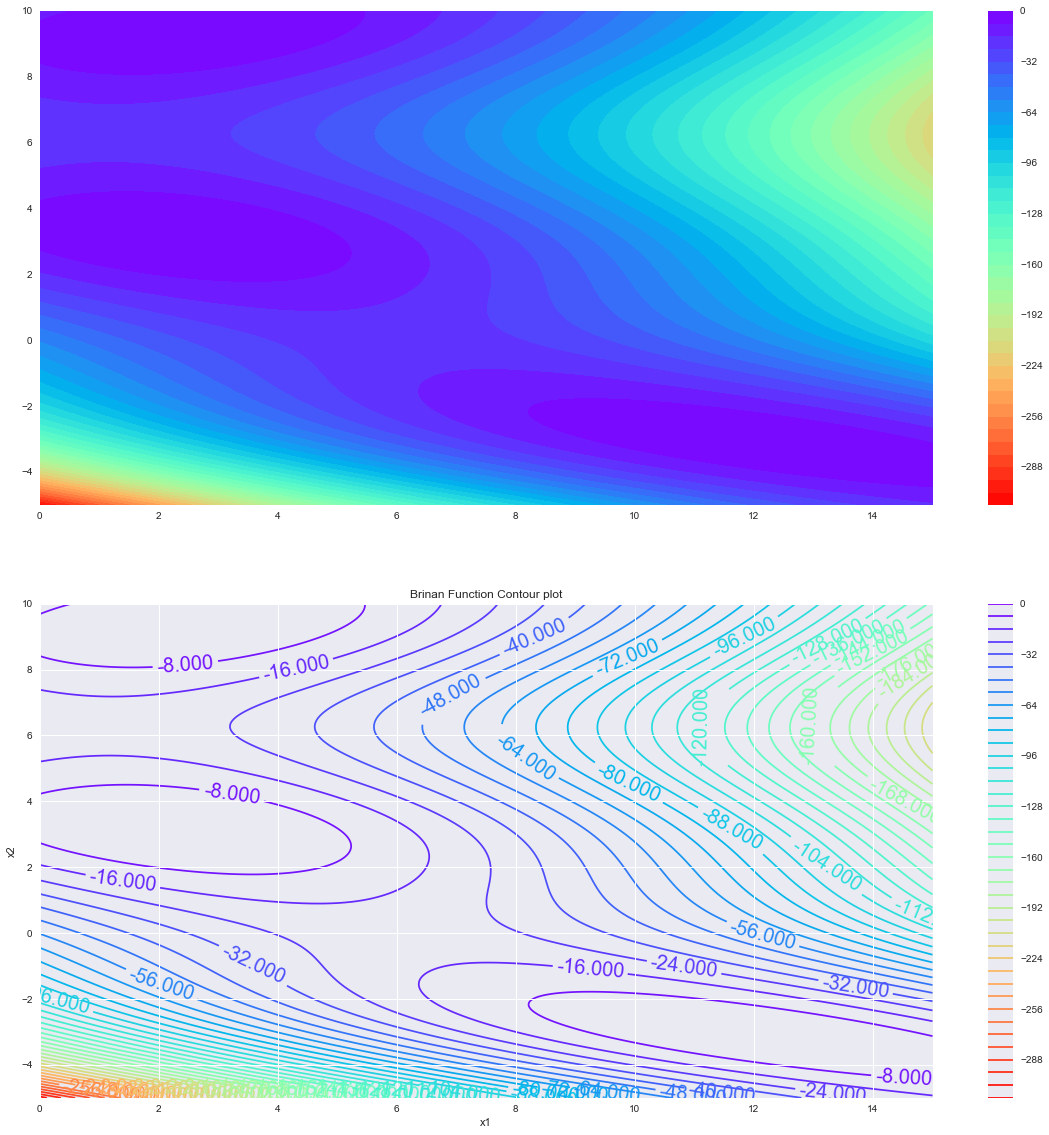

In [117]:
X,Y = np.meshgrid(x1,x2)
Z = Brainfunction(X,Y)
printmd('Brian Function')
contourFunction(Y,X,Z,50)

# Bayesian Simulation

## Initial knowledge and visualization

In [45]:
#def gpPredictFix(x):
#    return np.array([x[i] for i in x.keys()]).T

def posterior(bo, x):
    # Fit gaussian process
    bo.gp.fit(bo.X, bo.Y)
    # Create predict value (mu,sigma)
    Xinput = gpPredictFix(x)
    return bo.gp.predict(Xinput, return_std=True)

In [112]:
def plot_gp(bo, x, y, nbins=50, init= False,iters=5):
    
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)))
    
    gs = gridspec.GridSpec(1, 2)#,height_ratios=[1,1])
    #axTar = plt.subplot(gs[0, 0])
    axPre = plt.subplot(gs[0, 0])
    acq = plt.subplot(gs[0, 1])
    mu, sigma = posterior(bo, x)

    size = int(np.sqrt(len(x['x1'])))
    levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(y.min(),y.max())
    # Target
    #cp = axTar.contour(x['x1'].reshape(size,size), x['x2'].reshape(size,size), y, 
    #                   levels=levels,cmap=plt.get_cmap('rainbow_r'))
    #plt.clabel(cp, inline=True, fontsize=10)
     
    # Prediction
    cp = axPre.contour(x['x2'].reshape(size, size), x['x1'].reshape(size, size), mu.reshape(size, size) 
                  , levels=levels, cmap=plt.get_cmap('rainbow_r'))
    plt.clabel(cp, inline=True, fontsize=10)
    # PLOT SAMPLE POINT
    axPre.plot(bo.X[:,1], bo.X[:,0], 'D', markersize=6, label=u'Observations', color='r')
    if (init == False):
        axPre.plot(bo.X[:,1][-iters:], bo.X[:,0][-iters:], 'D', markersize=8, label=u'New Observations', color='g')
        
   
    # Utility Map
    Xinput = gpPredictFix(x)
    utility = bo.util.utility(Xinput, bo.gp, np.max(mu))
    levels=mpl.ticker.MaxNLocator(nbins=10).tick_values(utility.min(),utility.max())
    cp = acq.contour(x['x2'].reshape(size, size), x['x1'].reshape(size, size), utility.reshape(size, size), 
                label='Utility Function', levels=levels, cmap=plt.get_cmap('rainbow'))
    plt.clabel(cp, inline=True, fontsize=10)
    
    # Next sample Point 
    maxUtilityPoint = Xinput[np.argmax(utility)]
    acq.plot(maxUtilityPoint[1], maxUtilityPoint[0], '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='y', markeredgewidth=1)
    
    axPre.legend(loc=1, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=1, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1,top=0.95)
    plt.show()

##### Ploting data

In [113]:
X1sample = X.flatten()
X2sample = Y.flatten()
Z = Brainfunction(X,Y)
Xsample = {'x1':X1sample,'x2': X2sample}
gpParam = {"alpha": 1e-5, "n_restarts_optimizer": 2}

##### Define the  Bayesian Optimization function - initialization data

Initialization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
    1 | 00m00s |  -19.15899 |    8.3404 |    5.4066 | 
    2 | 00m00s |  -24.94462 |    8.3351 |    6.1124 | 
    3 | 00m00s |  -72.50702 |    0.0512 |   13.1934 | 
    4 | 00m00s | -142.01500 |    4.5465 |   12.9929 | 
    5 | 00m00s |  -54.57492 |    1.2904 |   10.6358 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 


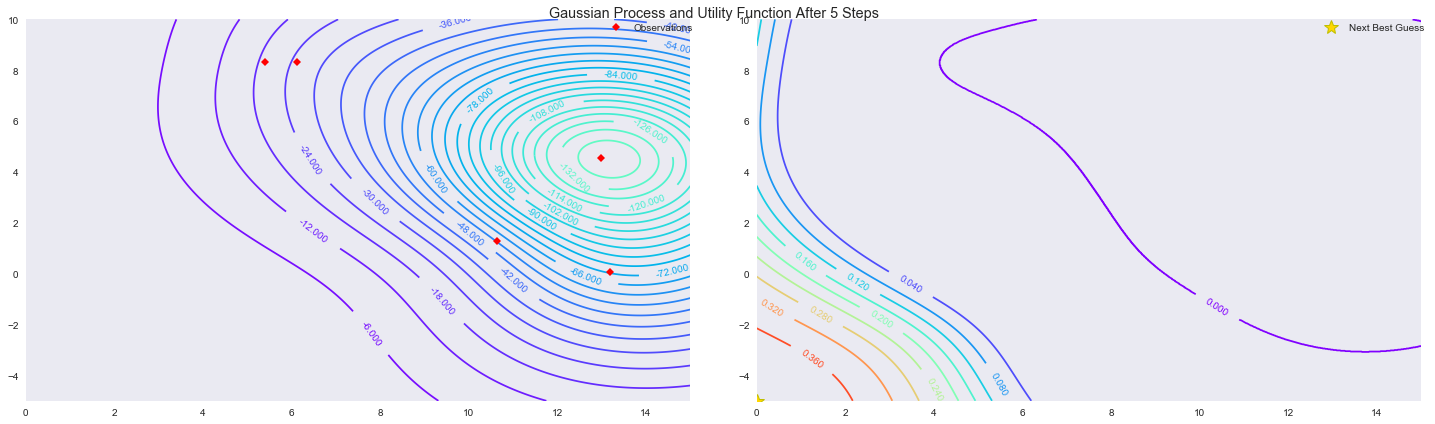

In [121]:
# from bayes_opt import BayesianOptimization
bo = BayesianOptimization(Brainfunction, {'x1': (-5, 10), 'x2': (0,15)})
bo.maximize(init_points=5, n_iter=0, acq='ei',**gpParam)
plot_gp(bo,Xsample,Z,60,init=True)


##### Run Bayesian Optimization by 10 steps

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
    6 | 00m00s | -300.65081 |   -4.9516 |    0.0665 | 


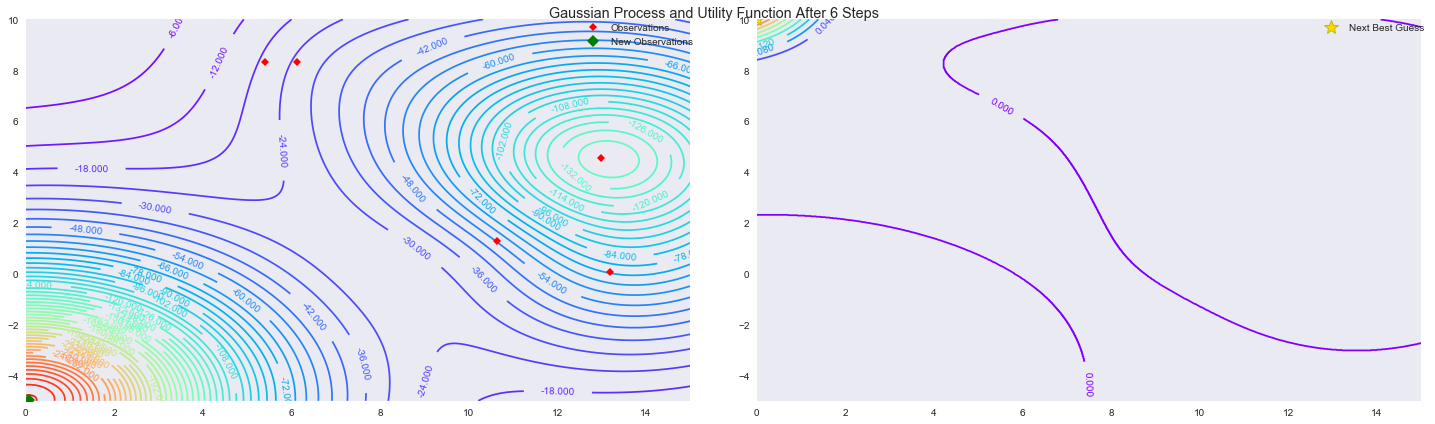

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
    7 | 00m00s |  -10.59723 |    9.9674 |    0.0009 | 


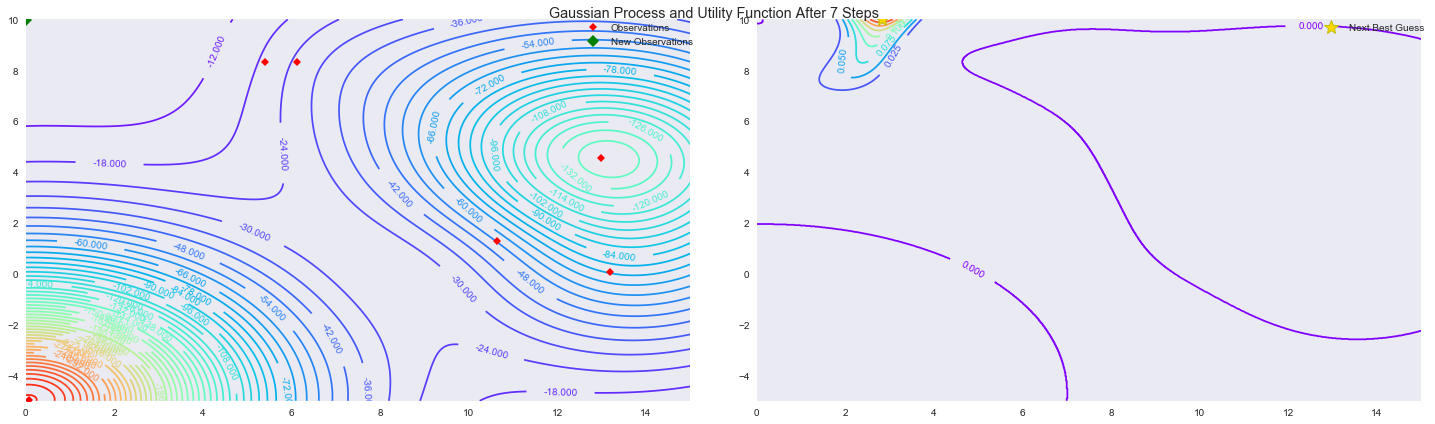

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
    8 | 00m00s |   -1.95613 |    9.9984 |    2.8559 | 


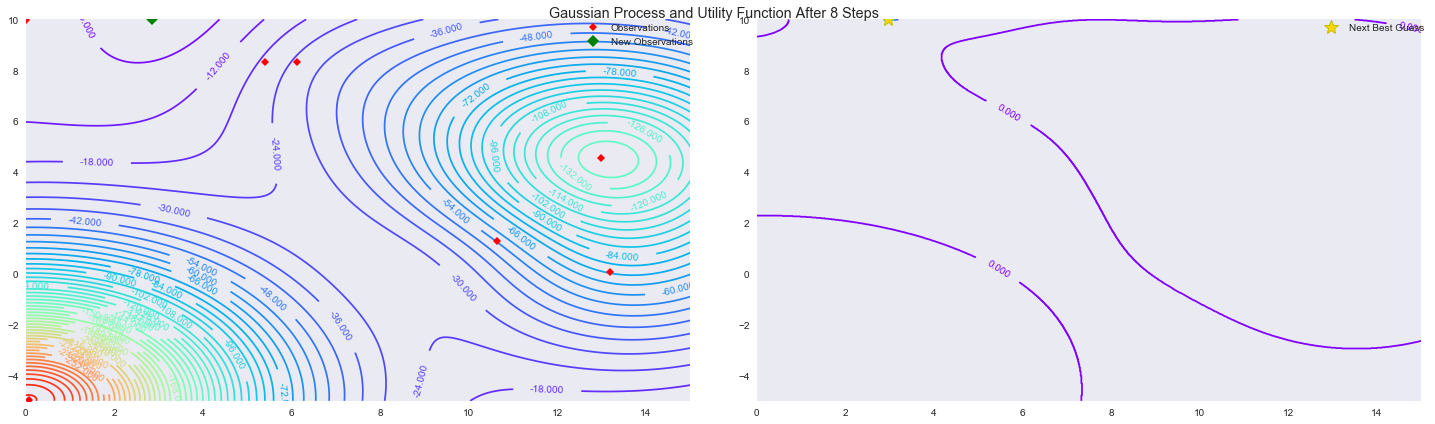

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
    9 | 00m00s |   -1.90563 |    9.9927 |    2.9800 | 


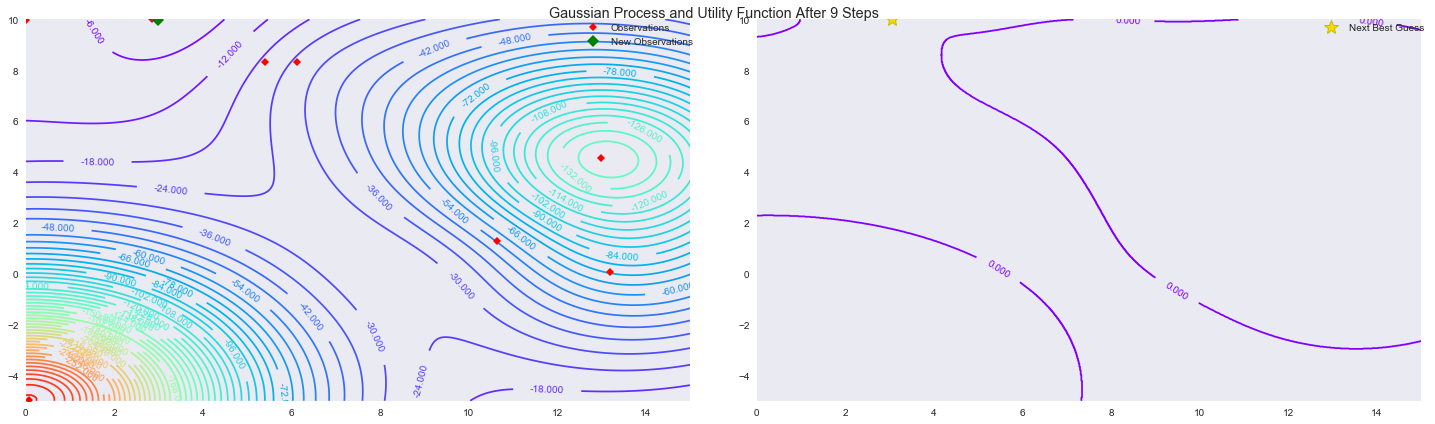

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   10 | 00m00s |   -1.94163 |    9.9997 |    3.0061 | 


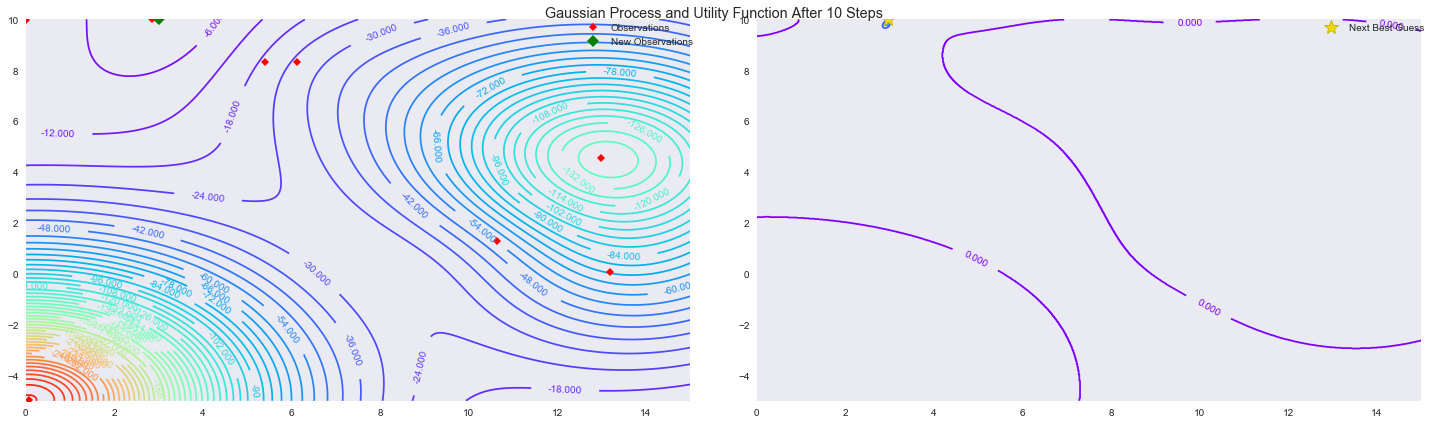

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   11 | 00m00s |   -1.00974 |    9.7766 |    2.9413 | 


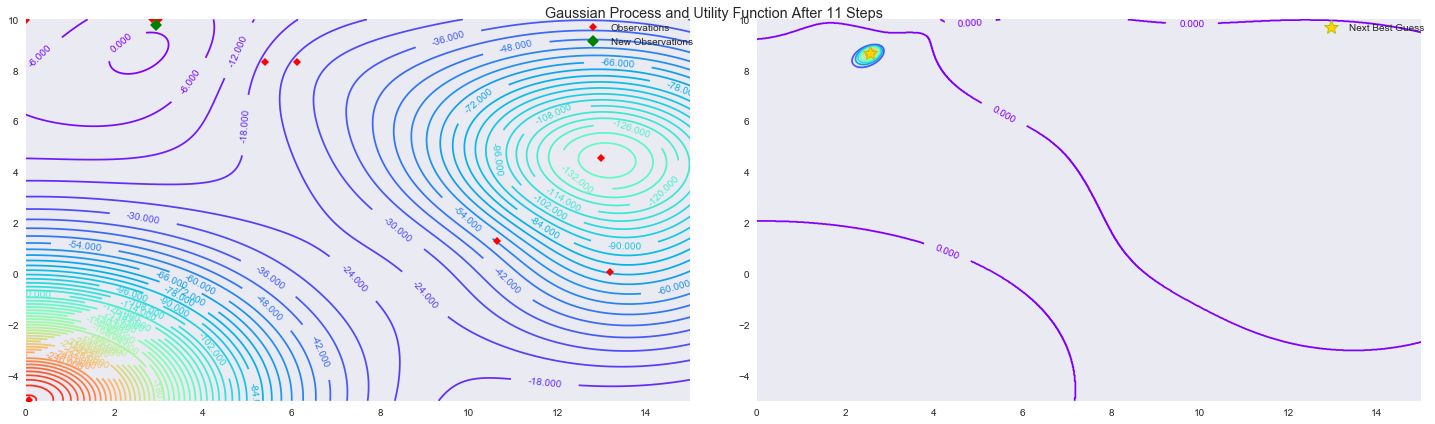

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   12 | 00m00s |   -3.02757 |    8.7328 |    2.6023 | 


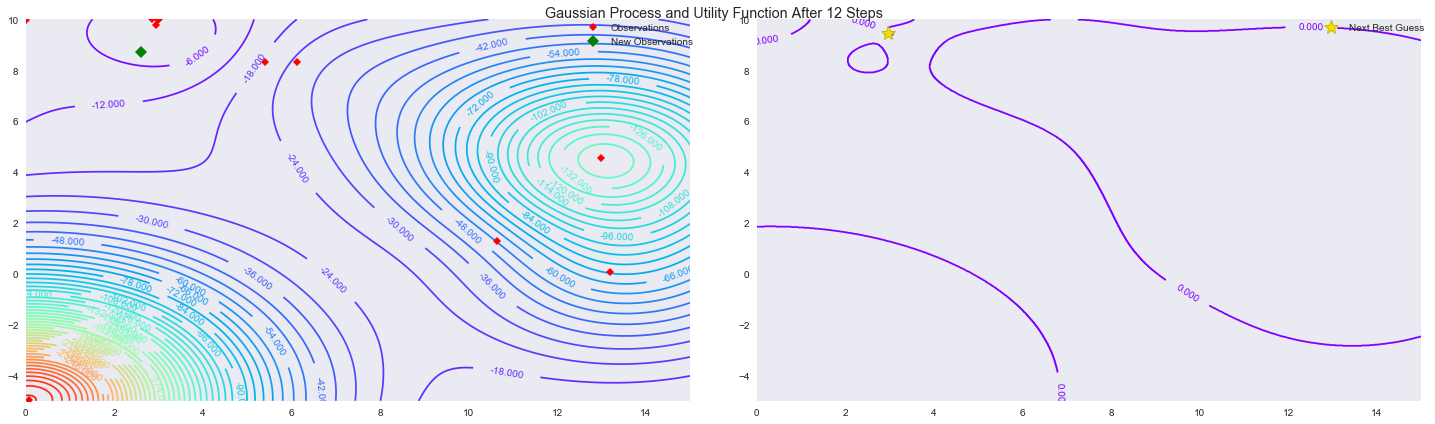

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   13 | 00m00s |   -0.65603 |    9.4329 |    2.9896 | 


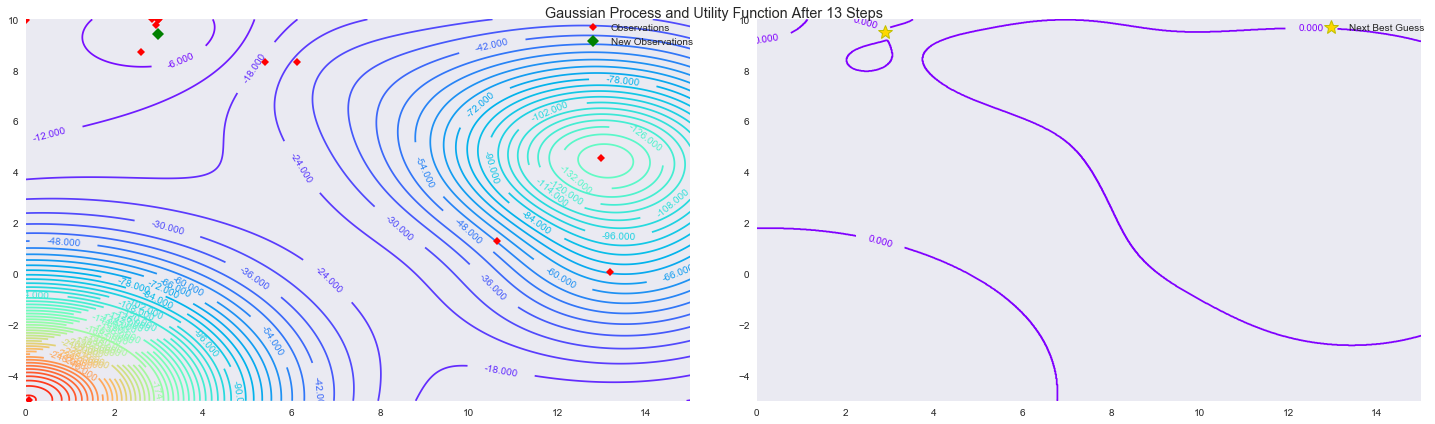

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   14 | 00m00s |   -0.60005 |    9.4749 |    2.9536 | 


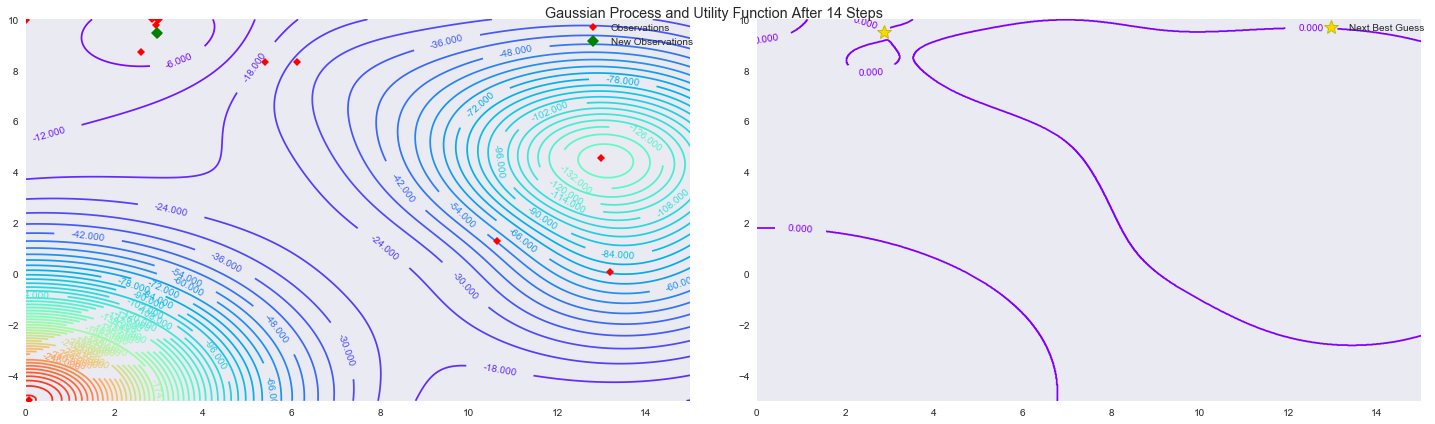

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   15 | 00m00s |   -0.54105 |    9.4868 |    2.8809 | 


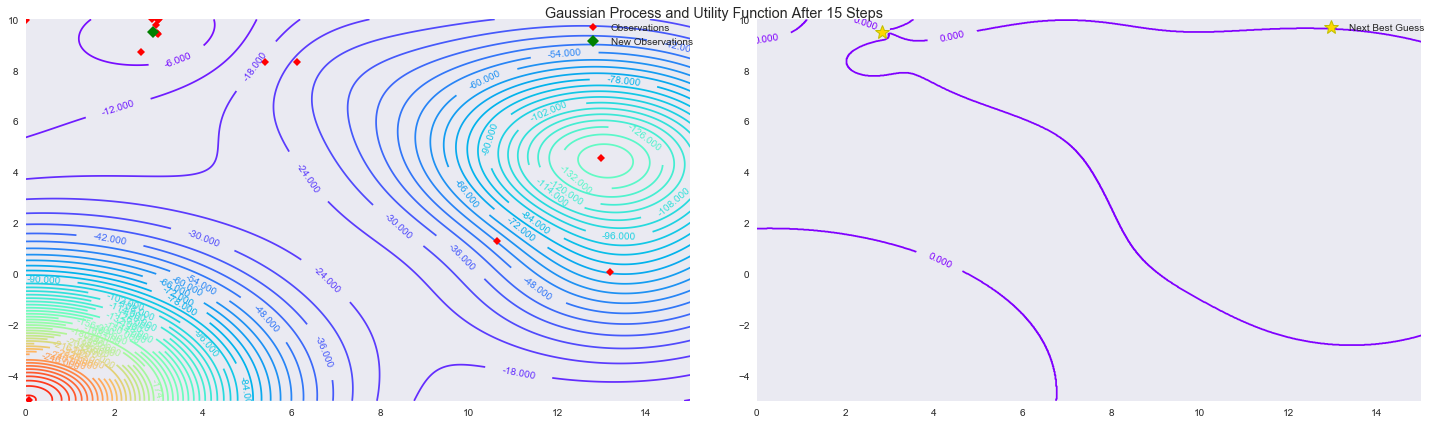

In [122]:
for i in range(10):
    bo.maximize(init_points=0, n_iter=1, acq='ei')
    plot_gp(bo,Xsample,Z,60, iters=1)

#### Simulation after several sampling 

In [127]:
def plot_gp_simulation(bo, x, y, ax, nbins=50):
    ax = title('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)))
    
    size = int(np.sqrt(len(x['x1'])))
    levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(y.min(),y.max())
    mu, sigma = posterior(bo, x)
    
    # Prediction
    cp = axPre.contour(x['x2'].reshape(size, size), x['x1'].reshape(size, size), mu.reshape(size, size) 
                  , levels=levels, cmap=plt.get_cmap('rainbow_r'))
    plt.clabel(cp, inline=True, fontsize=10)
    # PLOT SAMPLE POINT
    axPre.plot(bo.X[:,1], bo.X[:,0], 'D', markersize=6, label=u'Observations', color='r')
    if (init == False):
        axPre.plot(bo.X[:,1][-iters:], bo.X[:,0][-iters:], 'D', markersize=8, label=u'New Observations', color='g')
   
    ax.legend(loc=1, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

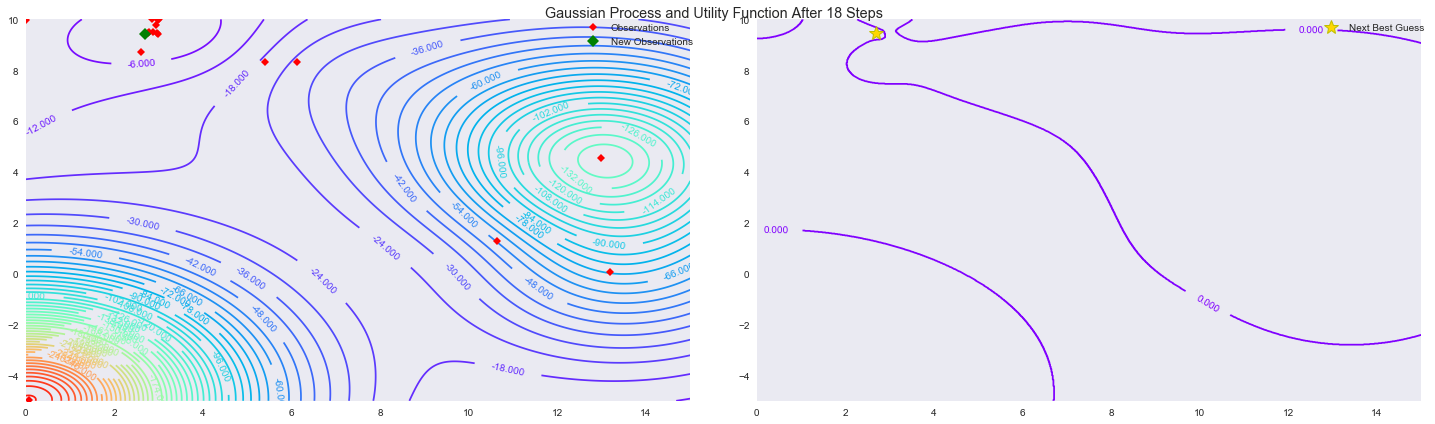

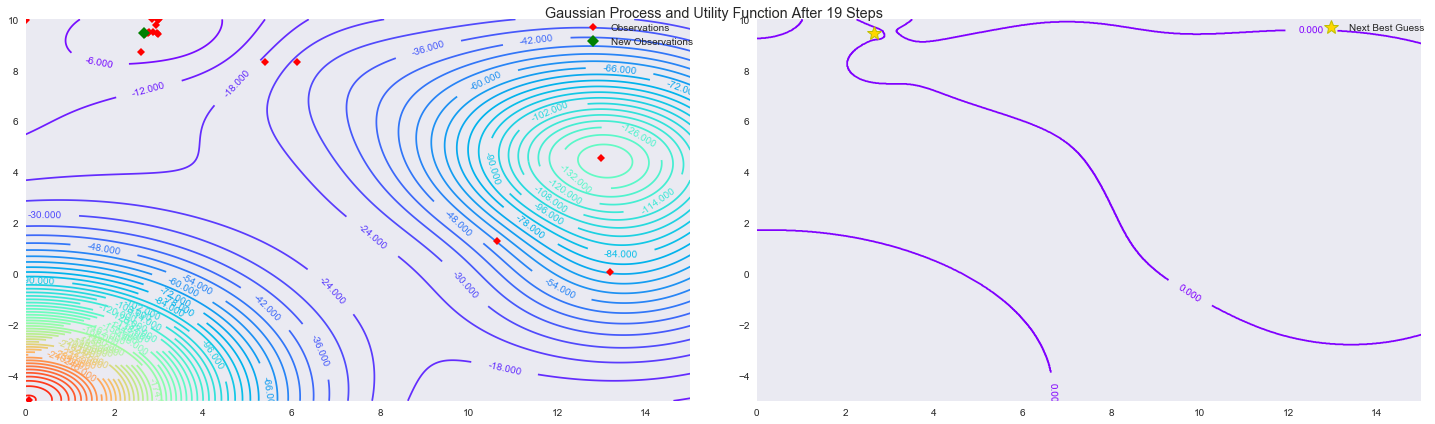

KeyboardInterrupt: 

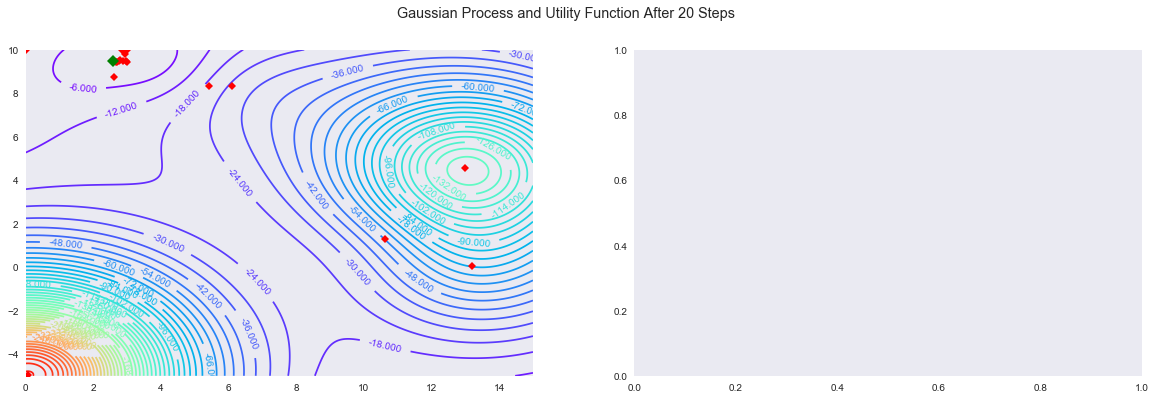

In [124]:
bo.verbose = False

gs = gridspec.GridSpec(, 2)#,height_ratios=[1,1])
    #axTar = plt.subplot(gs[0, 0])

for i in range(10):
    bo.maximize(init_points=0, n_iter=1, acq='ei')
    plot_gp(bo,Xsample,Z,60, iters=1)